## `Named Entity Recognition (NER)`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib, os
from sklearn.model_selection import train_test_split
import tensorflow as tf

np.random.seed(45)
tf.random.set_seed(45)
plt.style.use("ggplot")

* `Load the Dataset`

In [4]:
FILEPATH = os.path.join(os.getcwd(), '..', 'data', 'ner_dataset.csv')

df = pd.read_csv(FILEPATH, encoding='latin1')
df = df.fillna(method='ffill')
df.head(20)

<ipython-input-4-50e4f12bec56>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579018 entries, 0 to 579017
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Sentence #  579018 non-null  object
 1   Word        579018 non-null  object
 2   POS         579018 non-null  object
 3   Tag         579018 non-null  object
dtypes: object(4)
memory usage: 17.7+ MB


In [6]:
# Check uinuqe in Tag column
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [7]:
print('Unique words in corpus:', df['Word'].nunique())
print('Unique tags in corpus:', df['Tag'].nunique())

Unique words in corpus: 26554
Unique tags in corpus: 17


In [8]:
# Get unique words in corpus to a list
words = df['Word'].unique().tolist()

# 'ENDPAD' make that word for padding shorter sequences
words.append('ENDPAD')

# Length of unique words in corpus
num_words = len(words)
num_words

26555

In [9]:
# Get unique tags in the corpus to a list
tags = df['Tag'].unique().tolist()

# Length of unique tags in corpus
num_tags = len(tags)
num_tags

17

In [10]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [11]:
# Let's test on some samples
df_test = df.iloc[:50]

# Aggregation function for looping over the (Word, POS, Tag)
agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                s['POS'].values.tolist(),
                                                s['Tag'].values.tolist())]

grouped = df_test.groupby('Sentence #').apply(agg_func)
sentences = [s for s in grouped]
grouped

,0
Sentence #,
Sentence: 1,"[(Thousands, NNS, O), (of, IN, O), (demonstrat..."
Sentence: 2,"[(Families, NNS, O), (of, IN, O), (soldiers, N..."


* `Retrieve Sentences and Corresponsing Tags`

In [12]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sets = 1
        self.data = data

        self.agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                    s['POS'].values.tolist(),
                                                    s['Tag'].values.tolist())]

        self.grouped = self.data.groupby('Sentence #').apply(self.agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped[f"Sentence: {self.n_sent}"]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(df)
sentences = getter.sentences

In [13]:
print(len(sentences))
# sentences[200]

26469


* `Mapping between Sentences and Tags`

In [14]:
# Indexing words and tags
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

* `Padding Sentences`

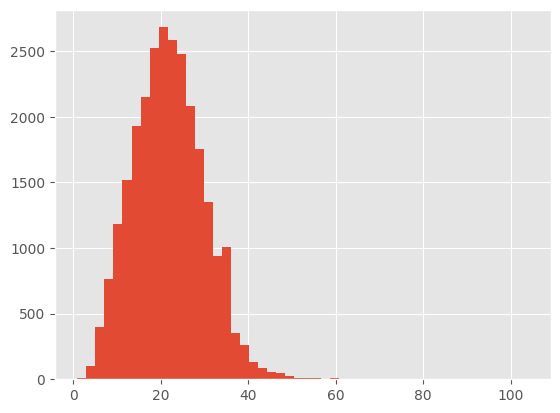

In [15]:
# Histogram represening the length of each sentences
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [28]:
# config
MAX_SEQUENCE_LENGTH = 50
EMBED_SIZE = 100
VOCAB_SIZE = num_words
NUM_OUTPUTS = num_tags
BATCH_SIZE = 32
EPOCHS = 20

In [17]:
# Indexing each word in each sentence (nested loop), for both words (X - Features), and tags (y - target)
X = [[word2idx[w[0]] for w in s] for s in sentences]
y = [[tag2idx[w[2]] for w in s] for s in sentences]

# padding
X = tf.keras.preprocessing.sequence.pad_sequences(sequences=X, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post', value=word2idx['ENDPAD'])  # words (X - Features)
y = tf.keras.preprocessing.sequence.pad_sequences(sequences=y, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post', value=tag2idx['O'])  # tags (y - target)

* `Split Dataset`

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21175, 50), (5294, 50), (21175, 50), (5294, 50))

In [19]:
y  # In Target (tags) : the first value in the second row (2)

array([[0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [0, 0, 7, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 6, ..., 0, 0, 0]], dtype=int32)

In [20]:
tag2idx   # see what (2) refer in tags (B-gpe) --> (Geopolitical Entity)

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16}

In [21]:
X  # In Features (words) : the first value in the second row (125)

array([[    1,     2,     3, ..., 26555, 26555, 26555],
       [  125,   126,   127, ..., 26555, 26555, 26555],
       [  943,   944,   364, ..., 26555, 26555, 26555],
       ...,
       [ 3184,   111,    69, ..., 26555, 26555, 26555],
       [ 6503,  3207,    94, ..., 26555, 26555, 26555],
       [   62,   581,   820, ..., 26555, 26555, 26555]], dtype=int32)

In [22]:
idx2word = {v: k for k, v in word2idx.items()}
idx2word.get(125)

'Iranian'

In [23]:
os.makedirs('../artifacts', exist_ok=True)
ARTIFACTS_FILE_PATH = os.path.join(os.getcwd(), '..', 'artifacts')


----

* `Model`

In [24]:
model = tf.keras.models.Sequential([
    # RNN base
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),

    # FC applied to each timestep
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(NUM_OUTPUTS, activation='softmax'))
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(loss='sparse_categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
chkpt = tf.keras.callbacks.ModelCheckpoint('model.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# fit
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping, chkpt])

Epoch 1/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - accuracy: 0.9874 - loss: 0.0467 - val_accuracy: 0.9842 - val_loss: 0.0573
Epoch 2/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 38s 37ms/step - accuracy: 0.9885 - loss: 0.0408 - val_accuracy: 0.9839 - val_loss: 0.0627
Epoch 3/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.9892 - loss: 0.0374 - val_accuracy: 0.9841 - val_loss: 0.0631
Epoch 4/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9897 - loss: 0.0352 - val_accuracy: 0.9838 - val_loss: 0.0658
Epoch 5/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.9901 - loss: 0.0336 - val_accuracy: 0.9841 - val_loss: 0.0673
Epoch 6/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.9908 - loss: 0.0311 - val_accuracy: 0.9836 - val_loss: 0.0685


In [30]:
# evaluate on test
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9833 - loss: 0.0713
Test Loss: 0.0685424953699112
Test Accuracy: 0.98357754945755


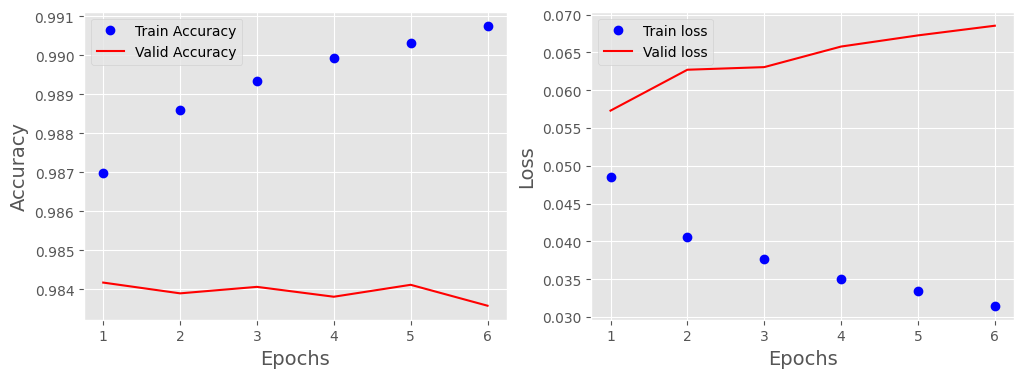

In [31]:
## Visualize the resutls
fia, ax = plt.subplots(1, 2, figsize=(12, 4))
n_epochs = len(history.history['loss'])  # real number of epochs in history, as we made early stopp
plt.sca(ax[0])
plt.plot(range(1, n_epochs+1), history.history['accuracy'], 'bo', label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history.history['val_accuracy'], 'r-', label='Valid Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy',  fontsize=14)
plt.legend()

plt.sca(ax[1])
plt.plot(range(1, n_epochs+1), history.history['loss'], 'bo', label='Train loss')
plt.plot(range(1, n_epochs+1), history.history['val_loss'], 'r-', label='Valid loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.legend()
plt.show()

In [40]:
ARTIFACTS_FILE_PATH = os.path.join(os.getcwd(), '..', 'artifacts')

joblib.dump(word2idx, os.path.join(ARTIFACTS_FILE_PATH, 'word2idx.joblib'), compress=9)  # save word2idx & tag2idx
joblib.dump(tag2idx, os.path.join(ARTIFACTS_FILE_PATH, 'tag2idx.joblib'), compress=9)

['ner-files/tag2idx.joblib']

In [41]:
# Load model, word2idx, and tag2idx
model = tf.keras.models.load_model('ner_model.keras')
word2idx = joblib.load('ner-files/word2idx.joblib')
tag2idx = joblib.load('ner-files/tag2idx.joblib')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 19 variables whereas the saved optimizer has 36 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [42]:
# From index to tag
idx2tag = {v:k for k, v in tag2idx.items()}

In [43]:
def inference(text: str):

    # Preprocess the input text
    X_new = [[word2idx.get(w, 0) for w in text.split()]]
    X_new_padded = tf.keras.preprocessing.sequence.pad_sequences(sequences=X_new,
                                                                maxlen=MAX_SEQUENCE_LENGTH,
                                                                padding='post',
                                                                truncating='post',
                                                                value=word2idx['ENDPAD'])
    # Predict tags
    predictions = model.predict(np.array([X_new_padded[0]]))
    predictions = np.argmax(predictions, axis=-1)[0]  # list of list

    # Map predictions back to tags
    predicted_tags = [idx2tag.get(idx, 'O') for idx in predictions]

    # Create a dictionary of word to predicted tag
    word_tag_pairs = dict(zip(text.split(), predicted_tags))

    return word_tag_pairs

In [44]:
text = 'this is Cairo from Egypt' # Test sample
inference(text=text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


{'this': 'O', 'is': 'O', 'Cairo': 'B-geo', 'from': 'O', 'Egypt': 'B-geo'}